In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys; sys.path.insert(0, '..')
from scripts.python.helpers import loadFeatureFilesFromImageTypes, loadImageDatasetConfig, savePlotFigure
from scripts.python.correlation_functions import getFeatureCorrelations, plotCorrelationHeatmap

# Load config file

In [2]:
dataset_name = "RADCURE"
config = loadImageDatasetConfig(dataset_name,
                                config_dir_path="../config")

# Set image feature extraction method

In [3]:
# Must be one of the directories in the procdata/{dataset_name} directory (not clinical)
extraction_method = "radiomics"
# extraction_method = "deep_learning"

print(f"Analyzing {extraction_method} features.")

Analyzing radiomics features.


# Load all feature sets

In [4]:
extracted_image_feature_dir = f"../../procdata/{dataset_name}/{extraction_method}/train_test_split/train_features"
image_feature_sets = loadFeatureFilesFromImageTypes(extracted_feature_dir = extracted_image_feature_dir,
                                image_types=config["image_types"],
                                drop_labels=True)

print("Feature sets available for analysis:")
for feature_set in image_feature_sets.keys():
    print("  ->", feature_set)

Feature sets available for analysis:
  -> original
  -> shuffled_full
  -> shuffled_roi
  -> shuffled_non_roi
  -> randomized_sampled_full
  -> randomized_sampled_roi
  -> randomized_sampled_non_roi


# Correlation Calculations

In [5]:
# Set up which feature sets to analyze
# This feature set will be used for the vertical axis (y-axis)
feature_set_vertical = "original"
# This feature set will be used for the horizontal axis (x-axis)
feature_set_horizontal = "shuffled_roi"

In [6]:
# Set up features for correlation calculation
vertical_features = image_feature_sets[feature_set_vertical]
horizontal_features = image_feature_sets[feature_set_horizontal]

# Select method
correlation_method = "pearson"

# Calculate Pearson correlation matrix
feature_correlation_matrix = getFeatureCorrelations(vertical_features = vertical_features, 
                                                    horizontal_features = horizontal_features,
                                                    method = correlation_method,
                                                    vertical_feature_name=feature_set_vertical,
                                                    horizontal_feature_name=feature_set_horizontal)

# Diagonal matrix of self-correlations

In [8]:
# Select out correlations for vertical vs vertical and horizontal vs horizontal
num_vertical_features = len(vertical_features.columns)
num_horizontal_features = len(horizontal_features.columns)

# Get the correlation matrix for vertical vs vertical
vertical_self_correlations = feature_correlation_matrix.iloc[0:num_vertical_features, 0:num_vertical_features]

horizontal_self_correlations = feature_correlation_matrix.iloc[num_vertical_features:, num_vertical_features:]

Saved out plot to ../../results/RADCURE/radiomics/correlation_heatmap_plots/RADCURE_pearson_corr_original_v_original_radiomics_plot.png


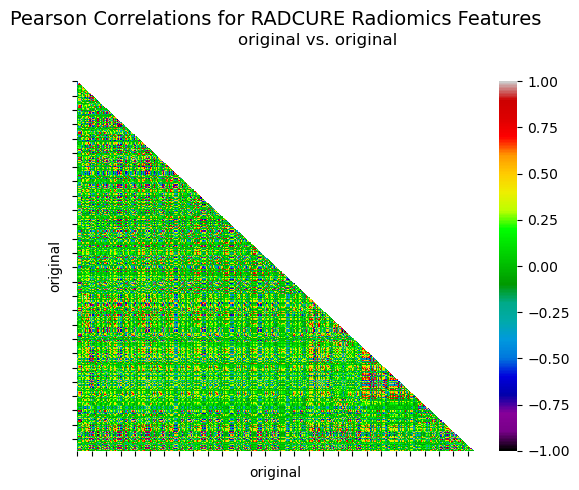

In [9]:
vertical_self_plot = plotCorrelationHeatmap(vertical_self_correlations,
                       diagonal = True,
                       triangle = "lower",
                       cmap = "nipy_spectral",
                       xlabel = feature_set_vertical,
                       ylabel = feature_set_vertical,
                       title = f"{correlation_method.capitalize()} Correlations for {dataset_name} {extraction_method.capitalize()} Features",
                       subtitle = f"{feature_set_vertical} vs. {feature_set_vertical}")

savePlotFigure(vertical_self_plot,
               plot_name=f"{dataset_name}_{correlation_method.lower()}_corr_{feature_set_vertical}_v_{feature_set_vertical}_{extraction_method.lower()}_plot.png",
               output_dir_path=f"../../results/{dataset_name}/{extraction_method.lower()}/correlation_heatmap_plots")

Saved out plot to ../../results/RADCURE/radiomics/correlation_heatmap_plots/RADCURE_pearson_corr_shuffled_roi_v_shuffled_roi_radiomics_plot.png


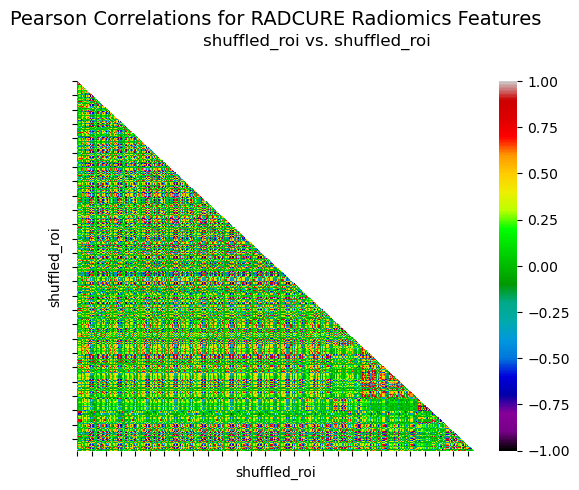

In [11]:
horizontal_self_plot = plotCorrelationHeatmap(correlation_matrix_df = horizontal_self_correlations,
                                              diagonal = True,
                                              triangle = "lower",
                                              cmap = "nipy_spectral",
                                              xlabel = feature_set_horizontal,
                                              ylabel = feature_set_horizontal,
                                              title = f"{correlation_method.capitalize()} Correlations for {dataset_name} {extraction_method.capitalize()} Features",
                                              subtitle = f"{feature_set_horizontal} vs. {feature_set_horizontal}")

savePlotFigure(horizontal_self_plot,
               plot_name=f"{dataset_name}_{correlation_method.lower()}_corr_{feature_set_horizontal}_v_{feature_set_horizontal}_{extraction_method.lower()}_plot.png",
               output_dir_path=f"../../results/{dataset_name}/{extraction_method.lower()}/correlation_heatmap_plots")

# Diagonal matrix of correlations between image types

# Distribution of corrrelations between features

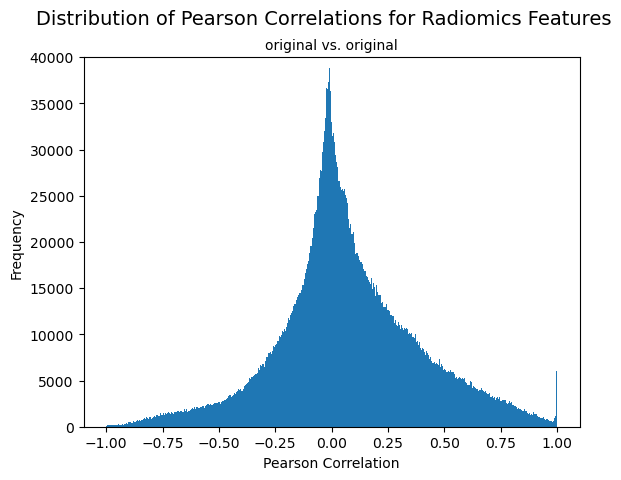

In [14]:
# flatten the correlation matrix to a vector
feature_correlation_arr = feature_correlation_matrix.to_numpy()
lower_half_idx = np.mask_indices(len(feature_correlation_matrix), np.tril)
diagonal_matrix_values = feature_correlation_arr[lower_half_idx]

# calculate histogram of distribution of correlations
correlation_distribution = np.histogram(diagonal_matrix_values, bins=100)

# Set up figure for histogram
dist_fig, dist_ax = plt.subplots()
_, bin_edges, _ = dist_ax.hist(diagonal_matrix_values, bins=450)
dist_ax.set_xlabel(f"{correlation_method.capitalize()} Correlation")
dist_ax.set_ylabel("Frequency")
dist_ax.set_ybound(0, 40000)
plt.suptitle(f"Distribution of {correlation_method.capitalize()} Correlations for {extraction_method.capitalize()} Features", fontsize=14)
plt.title(f"{feature_set_vertical} vs. {feature_set_horizontal}", fontsize=10)
plt.show()

## Save distribution plot

In [15]:
distribution_plot_name = f"{dataset_name}_{extraction_method}_correlation_distribution_{feature_set_vertical}_vs_{feature_set_horizontal}.png"
distribution_plot_output_dir_path = f"../../results/{dataset_name}/{extraction_method}/plot_figures/correlation_histogram_plots"

savePlotFigure(dist_fig, distribution_plot_name, distribution_plot_output_dir_path, dataset_name)

Saved out plot to ../../results/RADCURE/radiomics/plot_figures/correlation_histogram_plots/RADCURE_radiomics_correlation_distribution_original_vs_original.png


# Original vs Original correlation analysis

In [12]:
# matrix = np.triu(correlationMatrix)

In [32]:
len(correlationMatrix)/2 + 108

1425.0

In [ ]:
correlationMatrix.iloc[0:108, 1317:1425]

### No filter features

[Text(0.5, 23.38159722222222, 'shuffled_non_roi'),
 Text(50.581597222222186, 0.5, 'original'),
 [Text(0.5, 0, ''),
  Text(4.5, 0, ''),
  Text(8.5, 0, ''),
  Text(12.5, 0, ''),
  Text(16.5, 0, ''),
  Text(20.5, 0, ''),
  Text(24.5, 0, ''),
  Text(28.5, 0, ''),
  Text(32.5, 0, ''),
  Text(36.5, 0, ''),
  Text(40.5, 0, ''),
  Text(44.5, 0, ''),
  Text(48.5, 0, ''),
  Text(52.5, 0, ''),
  Text(56.5, 0, ''),
  Text(60.5, 0, ''),
  Text(64.5, 0, ''),
  Text(68.5, 0, ''),
  Text(72.5, 0, ''),
  Text(76.5, 0, ''),
  Text(80.5, 0, ''),
  Text(84.5, 0, ''),
  Text(88.5, 0, ''),
  Text(92.5, 0, ''),
  Text(96.5, 0, ''),
  Text(100.5, 0, ''),
  Text(104.5, 0, '')],
 [Text(0, 0.5, ''),
  Text(0, 5.5, ''),
  Text(0, 10.5, ''),
  Text(0, 15.5, ''),
  Text(0, 20.5, ''),
  Text(0, 25.5, ''),
  Text(0, 30.5, ''),
  Text(0, 35.5, ''),
  Text(0, 40.5, ''),
  Text(0, 45.5, ''),
  Text(0, 50.5, ''),
  Text(0, 55.5, ''),
  Text(0, 60.5, ''),
  Text(0, 65.5, ''),
  Text(0, 70.5, ''),
  Text(0, 75.5, ''),
  Te

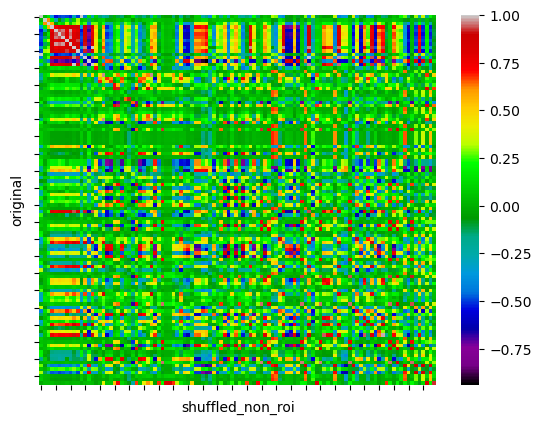

In [46]:
s = sns.heatmap(correlationMatrix.iloc[0:108, 1317:1425], cmap="nipy_spectral")
s.set(xlabel=horizontalPrefix, ylabel=verticalPrefix, xticklabels=[], yticklabels=[])
# plt.tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
# s.set_xticklabels(s.get_xticklabels(), rotation=40, ha="right")

### Wavelet Features

[Text(0.5, 23.38159722222222, 'shuffled_roi_'),
 Text(50.58159722222219, 0.5, 'original')]

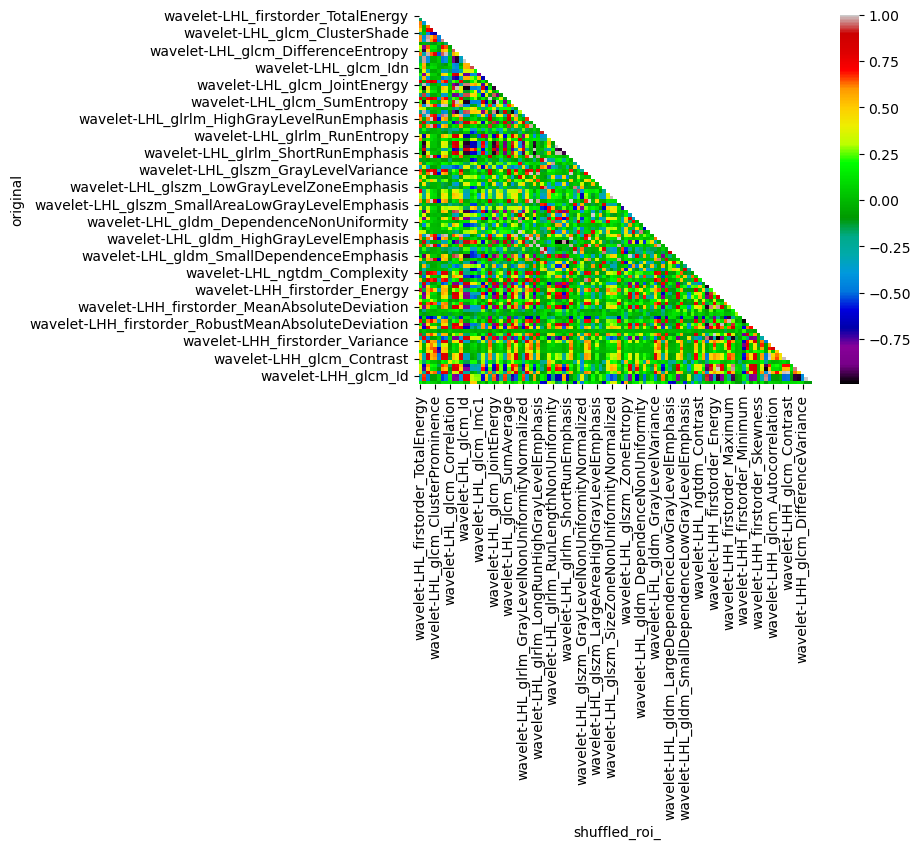

In [15]:
s = sns.heatmap(correlationMatrix.iloc[216:324, 216:324], mask=matrix[0:108, 0:108], cmap="nipy_spectral")
s.set(xlabel=horizontalPrefix, ylabel=verticalPrefix)